In [1]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Mounted at /content/gdrive
------------------------------------------------------------------


In [2]:
#export
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_02 import *
import torch.nn.functional as F
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

**Data**

In [3]:
mpl.rcParams["image.cmap"] = "gray"

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
n,m = x_train.shape
c = y_train.max() + 1
nh = 50

In [6]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
  def __call__(self, x):
    for l in self.layers: x = l(x)
    return x

In [7]:
model = Model(m,nh,10)

In [8]:
pred = model(x_train)

**Cross Entropy Loss**

In [9]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [10]:
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.3379, -2.2753, -2.2686,  ..., -2.2732, -2.4902, -2.1936],
        [-2.4079, -2.2219, -2.2125,  ..., -2.3647, -2.5307, -2.1432],
        [-2.3074, -2.2164, -2.2377,  ..., -2.3703, -2.5140, -2.0655],
        ...,
        [-2.3224, -2.2600, -2.2061,  ..., -2.3943, -2.4667, -2.0748],
        [-2.3132, -2.2889, -2.2526,  ..., -2.3858, -2.4522, -2.2371],
        [-2.3830, -2.3703, -2.2440,  ..., -2.3779, -2.4349, -2.1406]],
       grad_fn=<LogBackward>)

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.2434, -2.4079, -2.4417], grad_fn=<IndexBackward>)

In [13]:
x_train.shape[0]

50000

In [14]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [15]:
loss = nll(sm_pred, y_train)

In [16]:
loss

tensor(2.3129, grad_fn=<NegBackward>)

In [17]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [18]:
test_near(nll(log_softmax(pred), y_train), loss)

In [19]:
def logsumexp(x):
  m = x.max(-1)[0]
  return m + (x-m[:,None]).exp().sum(-1).log()

In [20]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [21]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim = True)

In [22]:
test_near(nll(log_softmax(pred),y_train), loss)

In [23]:
test_near(F.nll_loss(F.log_softmax(pred,-1), y_train), loss)

In [24]:
test_near(F.cross_entropy(pred, y_train), loss)

BASIC TRAINING LOOP

In [25]:
loss_func = F.cross_entropy

In [26]:
#export

def accuracy(out, yb): return (torch.argmax(out, dim = 1) == yb).float().mean()

In [27]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0]

tensor([-0.0577,  0.0049,  0.0116, -0.1152,  0.0055,  0.0368, -0.0245,  0.0070,
        -0.2100,  0.0866], grad_fn=<SelectBackward>)

In [28]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3130, grad_fn=<NllLossBackward>)

In [29]:
accuracy(preds, yb)

tensor(0.1250)

In [30]:
lr = 0.5
epochs = 1

In [31]:
for epoch in range(epochs):
  for i in range((n-1)//bs + 1):
    start_i = i*bs
    end_i = start_i*bs

    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]

    loss = loss_func(model(xb), yb)

    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, "weight"):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr

          l.weight.grad.zero_()
          l.bias.grad.zero_()

In [32]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0085, grad_fn=<NllLossBackward>), tensor(1.))

**UNSING PARAMEMTERS AND OPTIM**

Parameters

In [33]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
    self.Relu = nn.ReLU()

  def __call__(self, x): return self.l2( self.Relu( self.l1(x) ) )

In [34]:
model = Model(m, nh, 10)

In [35]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
Relu: ReLU()


In [36]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (Relu): ReLU()
)

In [37]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
def fit():
  for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
      start_i = i*bs
      end_i  = start_i+bs

      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]

      loss = loss_func(model(xb), yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters(): p -= p.grad * lr
        model.zero_grad()

In [39]:
#model??

In [40]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2759, grad_fn=<NllLossBackward>), tensor(0.9375))

**nn.ModuleList**

In [41]:
layers = [nn.Linear(m, nh),nn.ReLU(), nn.Linear(nh, 10)]

In [42]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)

  def __call__(self, x):
    for l in self.layers: x = l(x)
    return x

In [43]:
model = SequentialModel(layers)

In [44]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

**nn.Sequential**

In [45]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [46]:
fit()
loss_func(model(xb) , yb), accuracy(model(xb), yb)

(tensor(0.0719, grad_fn=<NllLossBackward>), tensor(1.))

In [47]:
nn.Sequential??

In [48]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

**OPtim**

In [49]:
class Optimizer():
  def __init__(self, params, lr = 0.5):
    self.params, self.lr = list(params), lr
  
  def step(self):
    with torch.no_grad():
      for p in self.params: p -= p.grad * lr

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()

In [50]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [51]:
opt = Optimizer(model.parameters())

In [52]:
for epoch in range(epochs):
  for i in range((n-1)//bs + 1):
    start_i = i*bs
    end_i = start_i+bs

    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]

    pred = model(xb)

    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

In [53]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

loss, acc

(tensor(0.2622, grad_fn=<NllLossBackward>), tensor(0.9375))

In [54]:
#export

from torch import optim

In [55]:
optim.SGD.step??

In [56]:
def get_model():
  model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
  return model, optim.SGD(model.parameters(), lr=lr)

In [57]:
for epoch in range(epochs):
  for i in range((n-1)//bs + 1):
    start_i = i*bs
    end_i = start_i +bs

    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]

    loss = loss_func(model(xb),yb)

    loss.backward()
    opt.step()
    opt.zero_grad()


In [58]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

loss, acc

(tensor(0.0128, grad_fn=<NllLossBackward>), tensor(1.))

In [59]:
assert acc >0.7

**DATASET AND DATALOADER**

In [60]:
#export
class Dataset():
  def __init__(self, x, y): self.x,self.y = x,y
  def __len__(self): return len(self.x)
  def __getitem__(self, i): return self.x[i], self.y[i]

In [61]:
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

assert(len(train_ds) == len(x_train))
assert(len(valid_ds) == len(x_valid))

In [62]:
xb,yb = train_ds[0:5]

assert xb.shape == (5, 28*28)
assert yb.shape == (5, )

xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [63]:
model,opt = get_model()

In [64]:
for epoch in range(epochs):
  for i in range((n-1)//bs +1):
    xb,yb = train_ds[i*bs: i*bs+bs]

    pred = model(xb)
    loss = loss_func(model(xb),yb)
    loss.backward()

    opt.step()
    opt.zero_grad()

In [65]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb),yb)

loss, acc

(tensor(0.1121, grad_fn=<NllLossBackward>), tensor(0.9375))

In [66]:
class DataLoader():
  def __init__(self, ds, bs): self.ds,self.bs = ds,bs

  def __iter__(self):
    for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [67]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [68]:
xb,yb = next(iter(valid_dl))

assert xb.shape == (bs, 28*28)
assert yb.shape == (bs,)


tensor(3)

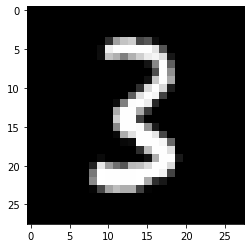

In [69]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [70]:
model, opt = get_model()

In [71]:
def fit():
  for epoch in range(epochs):
    for xb,yb in train_dl:

      pred = model(xb)
      loss = loss_func(pred, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()


In [72]:
fit()

In [73]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb),yb)

loss,acc

(tensor(0.0935, grad_fn=<NllLossBackward>), tensor(0.9844))

**RANDOM SAMPLING**

In [74]:
class Sampler():
  def __init__(self, ds,bs,shuffle=False):
    self.n, self.bs,self.shuffle = len(ds),bs,shuffle

  def __iter__(self):
    self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
    for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [75]:
small_ds = Dataset(*train_ds[:10])

In [76]:
s = Sampler(small_ds,3,False)
[it for it in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [77]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([0, 2, 7]), tensor([4, 3, 8]), tensor([1, 9, 5]), tensor([6])]

In [78]:
def collate(b):
  xs,ys = zip(*b)
  return torch.stack(xs),torch.stack(ys)

class DataLoader():
  def __init__(self, ds, sampler, collate_fn = collate):
    self.ds,self.sampler, self.collate_fn = ds,sampler,collate_fn

  def __iter__(self):
    for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])


In [79]:
train_samp = Sampler(train_ds, bs, shuffle = True)
valid_samp = Sampler(valid_ds, bs, shuffle = False)

In [80]:
train_dl = DataLoader(train_ds, sampler = train_samp, collate_fn = collate)
valid_dl = DataLoader(valid_ds, sampler = valid_samp, collate_fn = collate)

tensor(3)

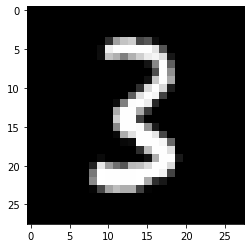

In [81]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(4)

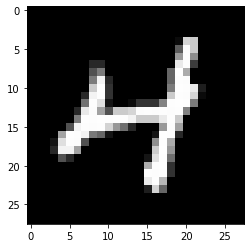

In [82]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [83]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb),yb), accuracy(model(xb), yb)
assert acc > 0.7

loss,acc

(tensor(0.2218, grad_fn=<NllLossBackward>), tensor(0.9531))

In [84]:
#export

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [85]:
train_dl = DataLoader(train_ds, bs, sampler = RandomSampler(train_ds), collate_fn = collate)
valid_dl = DataLoader(valid_ds, bs, sampler = SequentialSampler(valid_ds), collate_fn = collate)

In [86]:
model, opt = get_model()
fit()

loss_func(model(xb),yb), accuracy(model(xb), yb)

(tensor(0.2048, grad_fn=<NllLossBackward>), tensor(0.9375))

In [87]:
train_dl = DataLoader(train_ds, bs,shuffle = True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle = False)

In [88]:
model, opt = get_model()
fit()

loss_func(model(xb),yb), accuracy(model(xb), yb)

(tensor(0.2512, grad_fn=<NllLossBackward>), tensor(0.9219))

**VALIDATION**

In [89]:
def fit(epochs, model, loss_func, opt,train_dl,valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb,yb in train_dl:
      loss = loss_func(model(xb), yb)
      loss.backward()
      opt.step()
      opt.zero_grad()

    model.eval()
    with torch.no_grad():
      tot_loss, tot_acc = 0.,0.
      for xb,yb in valid_dl:
        pred = model(xb)
        tot_loss += loss_func(pred,yb)
        tot_acc += accuracy(pred,yb)

    nv = len(valid_dl)
    print(epoch, tot_loss/nv, tot_acc/nv)
  return tot_loss/nv, tot_acc/nv

In [95]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
  return (DataLoader(train_ds, batch_size=bs,shuffle= True, **kwargs),
          DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [91]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()

loss,acc = fit(10, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1675) tensor(0.9517)
1 tensor(0.1643) tensor(0.9533)
2 tensor(0.1011) tensor(0.9701)
3 tensor(0.0934) tensor(0.9720)
4 tensor(0.1149) tensor(0.9655)
5 tensor(0.1053) tensor(0.9692)
6 tensor(0.1032) tensor(0.9704)
7 tensor(0.1100) tensor(0.9691)
8 tensor(0.1009) tensor(0.9723)
9 tensor(0.0981) tensor(0.9729)


In [92]:
assert acc>0.9

In [93]:
!pip install fire

     |████████████████████████████████| 81kB 3.7MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111006 sha256=977204b3bd2e7adad9356e5ed3f2891c98d694fdf633118177be334433840fc4
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire


In [94]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
